In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import scipy
import matplotlib.pyplot as plt
import sklearn 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("DS - Assignment Part 1 data set.xlsx")
data.head()

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,1,575,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,2,1240,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,3,1060,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,2,875,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,1,491,43.1


In [4]:
data.shape

(414, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Transaction date                          414 non-null    float64
 1   House Age                                 414 non-null    float64
 2   Distance from nearest Metro station (km)  414 non-null    float64
 3   Number of convenience stores              414 non-null    int64  
 4   latitude                                  414 non-null    float64
 5   longitude                                 414 non-null    float64
 6   Number of bedrooms                        414 non-null    int64  
 7   House size (sqft)                         414 non-null    int64  
 8   House price of unit area                  414 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 29.2 KB


In [6]:
data['Transaction date'] = data['Transaction date'].astype(int)
data['House Age'] = data['House Age'].astype(int)
data['Distance from nearest Metro station (km)'] = data['Distance from nearest Metro station (km)'].astype(int)
data['latitude'] = data['latitude'].astype(int)
data['longitude'] = data['longitude'].astype(int)
data['House price of unit area'] = data['House price of unit area'].astype(int)

In [7]:
data.describe()

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.0,414.000000,414.000000,414.000000
mean,2012.695652,17.292271,1083.376812,4.094203,24.004831,121.0,1.987923,931.475845,37.543478
std,0.460687,11.333769,1262.159441,2.945562,0.069421,0.0,0.818875,348.910269,13.641086
min,2012.000000,0.000000,23.000000,0.000000,24.000000,121.0,1.000000,402.000000,7.000000
25%,2012.000000,9.000000,289.000000,1.000000,24.000000,121.0,1.000000,548.000000,27.000000
50%,2013.000000,16.000000,492.000000,4.000000,24.000000,121.0,2.000000,975.000000,38.000000
75%,2013.000000,28.000000,1453.500000,6.000000,24.000000,121.0,3.000000,1234.750000,46.000000
max,2013.000000,43.000000,6488.000000,10.000000,25.000000,121.0,3.000000,1500.000000,117.000000


difference between mean and max of price feature is very high. So there is possibility of some outliers. We will detect them in further plots.

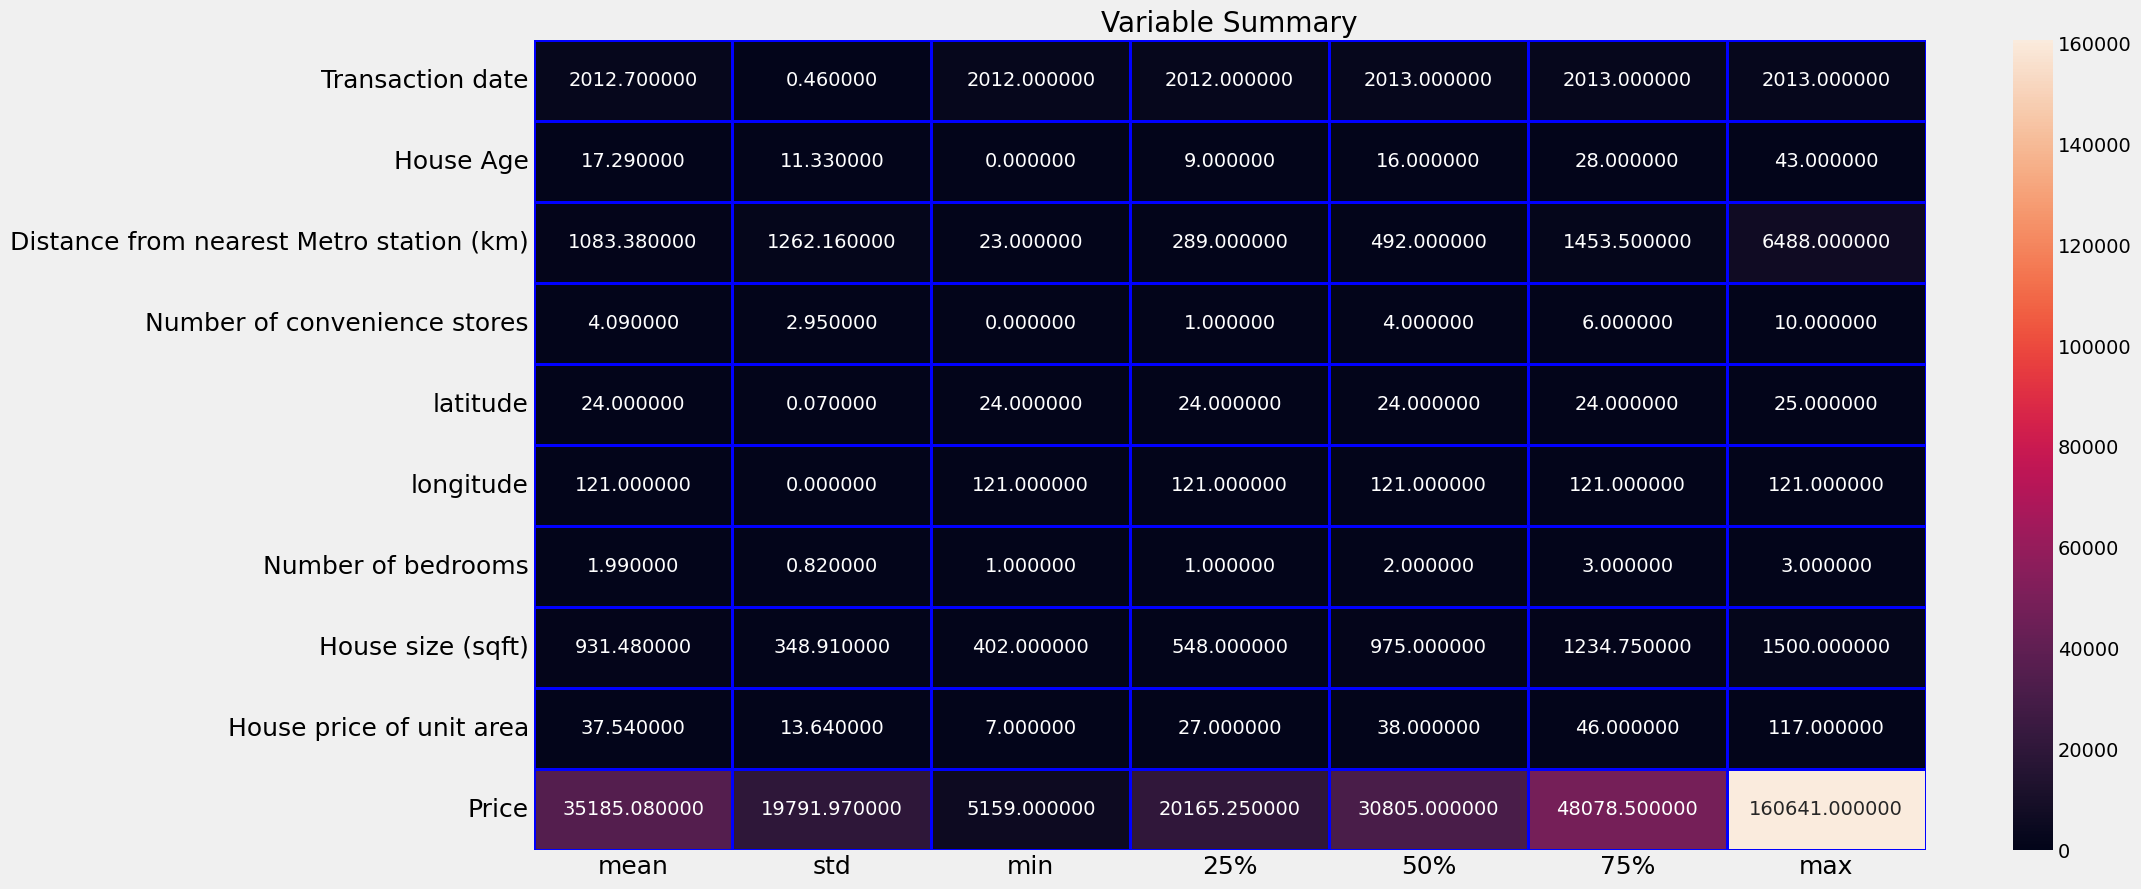

In [33]:
plt.figure(figsize=(20,10))
sns.heatmap(round(data.describe()[1:].transpose(),2),lw=2,linecolor='blue',annot=True,fmt='f',color='white')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Variable Summary')
plt.show()

In [8]:
#checking null vALUES
data.isnull().sum()

Transaction date                            0
House Age                                   0
Distance from nearest Metro station (km)    0
Number of convenience stores                0
latitude                                    0
longitude                                   0
Number of bedrooms                          0
House size (sqft)                           0
House price of unit area                    0
dtype: int64

In [9]:
data['longitude'].value_counts()

121    414
Name: longitude, dtype: int64

In [10]:
data['latitude'].value_counts()

24    412
25      2
Name: latitude, dtype: int64

In [11]:
data['Price'] = data['House size (sqft)']*data['House price of unit area']
data.head()

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area,Price
0,2012,32,84,10,24,121,1,575,37,21275
1,2012,19,306,9,24,121,2,1240,42,52080
2,2013,13,561,5,24,121,3,1060,47,49820
3,2013,13,561,5,24,121,2,875,54,47250
4,2012,5,390,5,24,121,1,491,43,21113


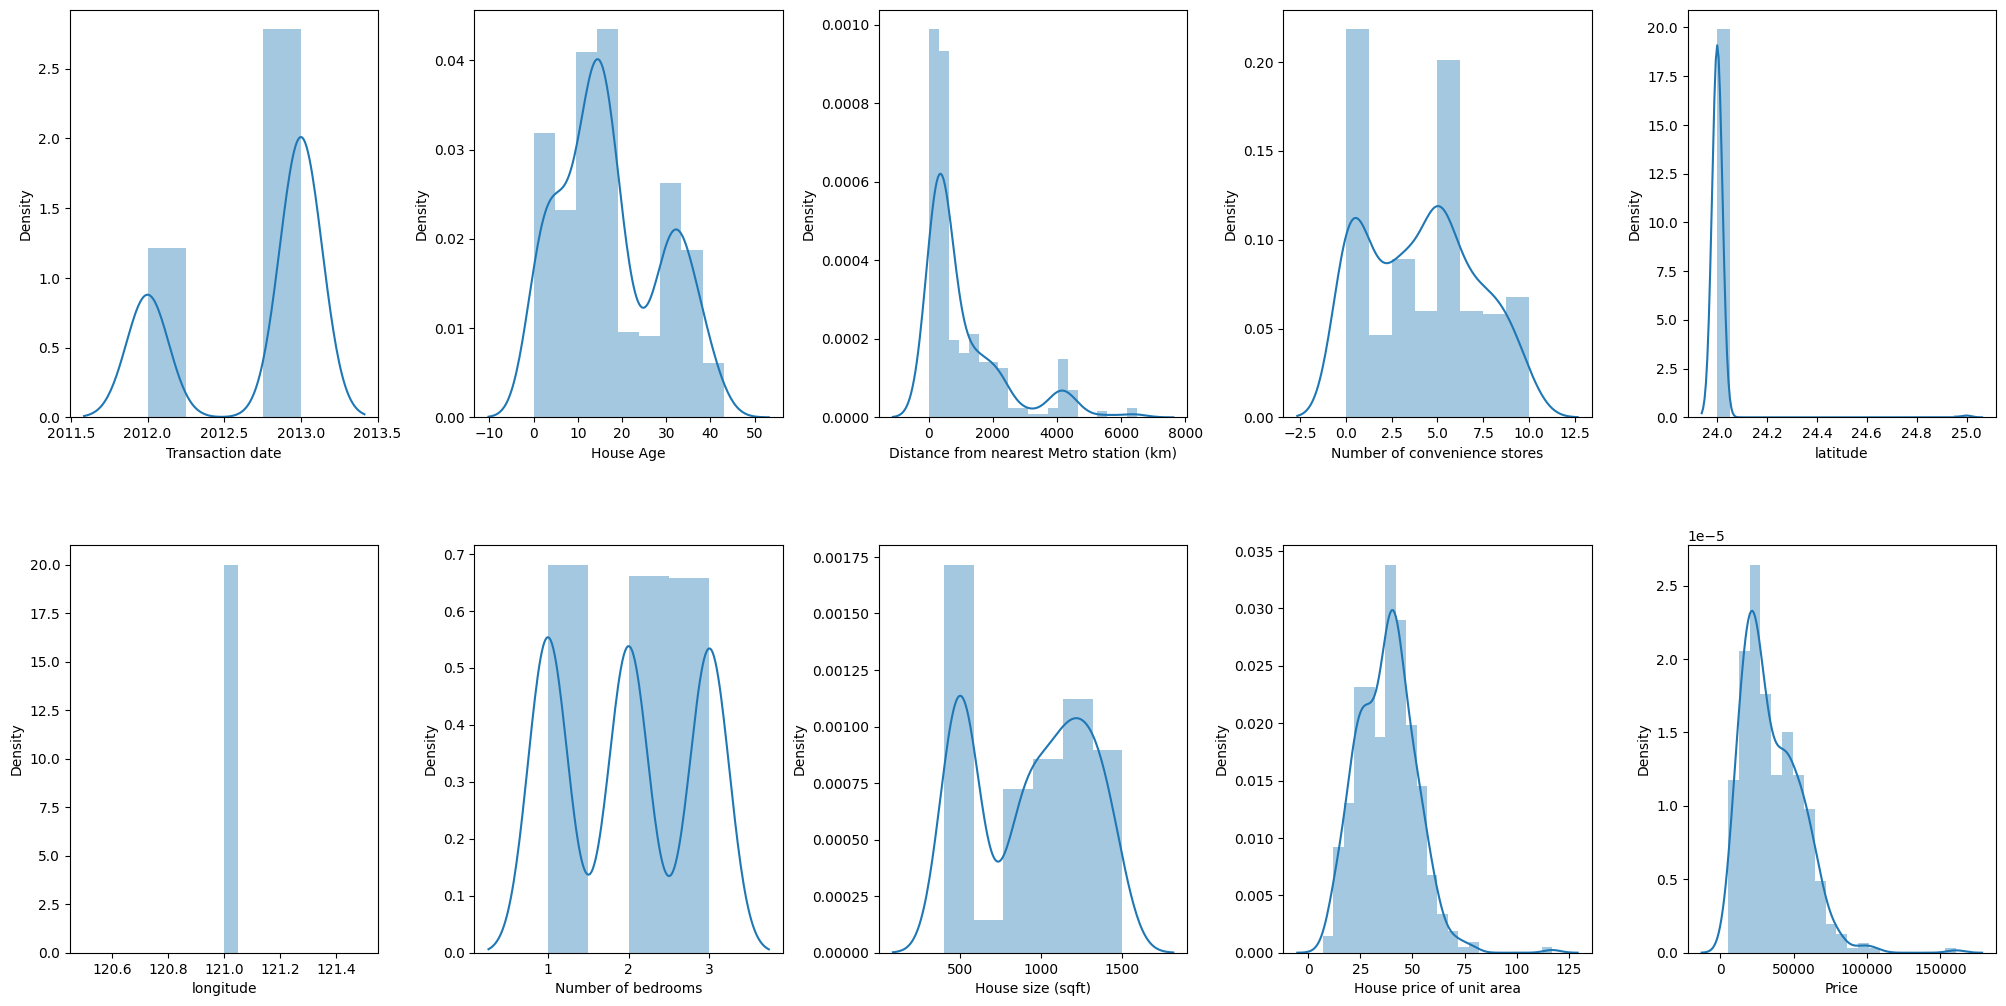

In [12]:
#dist plot
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.distplot(value, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

<AxesSubplot: >

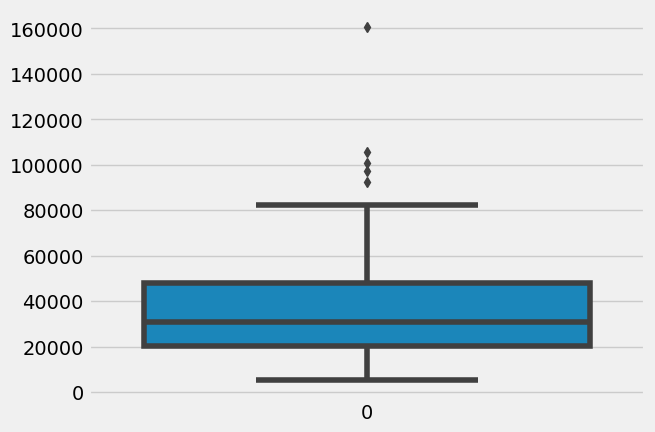

In [28]:
sns.boxplot(data['Price'])

There is one data point whose price is 160k which is very high than others. We can consider it as outliers.

<AxesSubplot: xlabel='Price', ylabel='Density'>

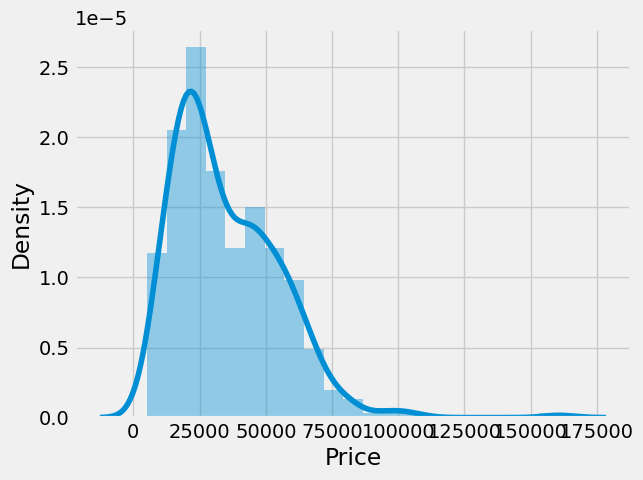

In [29]:
sns.distplot(data['Price'])

It can be seen from plot that price is right skewed and majority lies between 20k to 70k.

<AxesSubplot: xlabel='House price of unit area', ylabel='Price'>

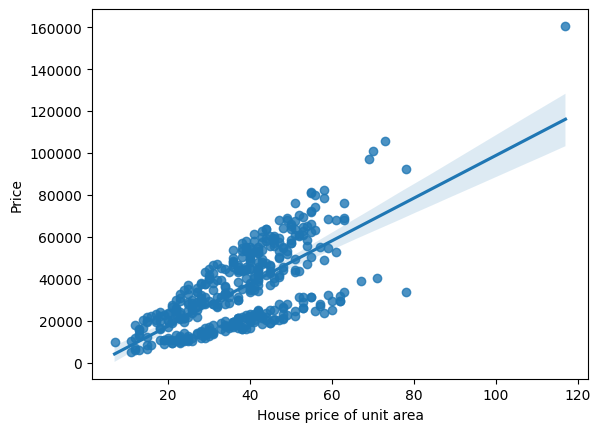

In [17]:
sns.regplot(y=data['Price'], x=data['House price of unit area'])

<AxesSubplot: xlabel='House size (sqft)', ylabel='Price'>

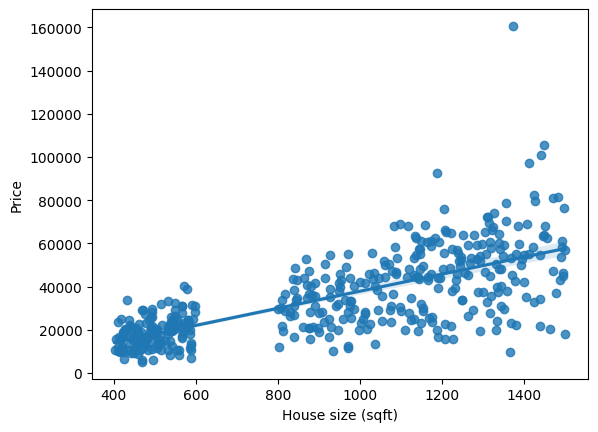

In [19]:
sns.regplot(y=data['Price'], x=data['House size (sqft)'])

<AxesSubplot: xlabel='Distance from nearest Metro station (km)', ylabel='Price'>

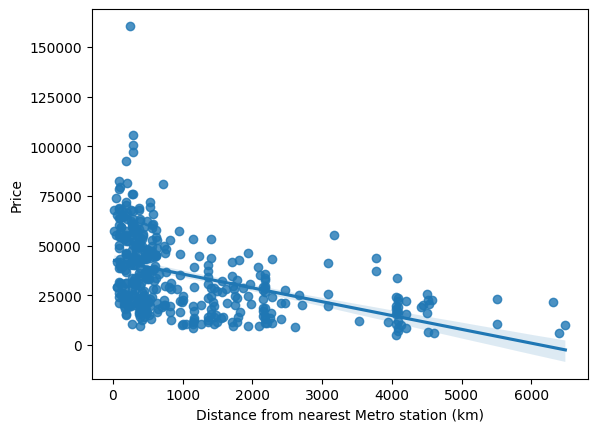

In [20]:
sns.regplot(y=data['Price'], x=data['Distance from nearest Metro station (km)'])

In [13]:
data.loc[data['Price']> 130000]

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area,Price
270,2013,10,252,1,24,121,2,1373,117,160641


Above data point has outlier which need to be removed

In [14]:
data= data[data['Price']<= 130000]

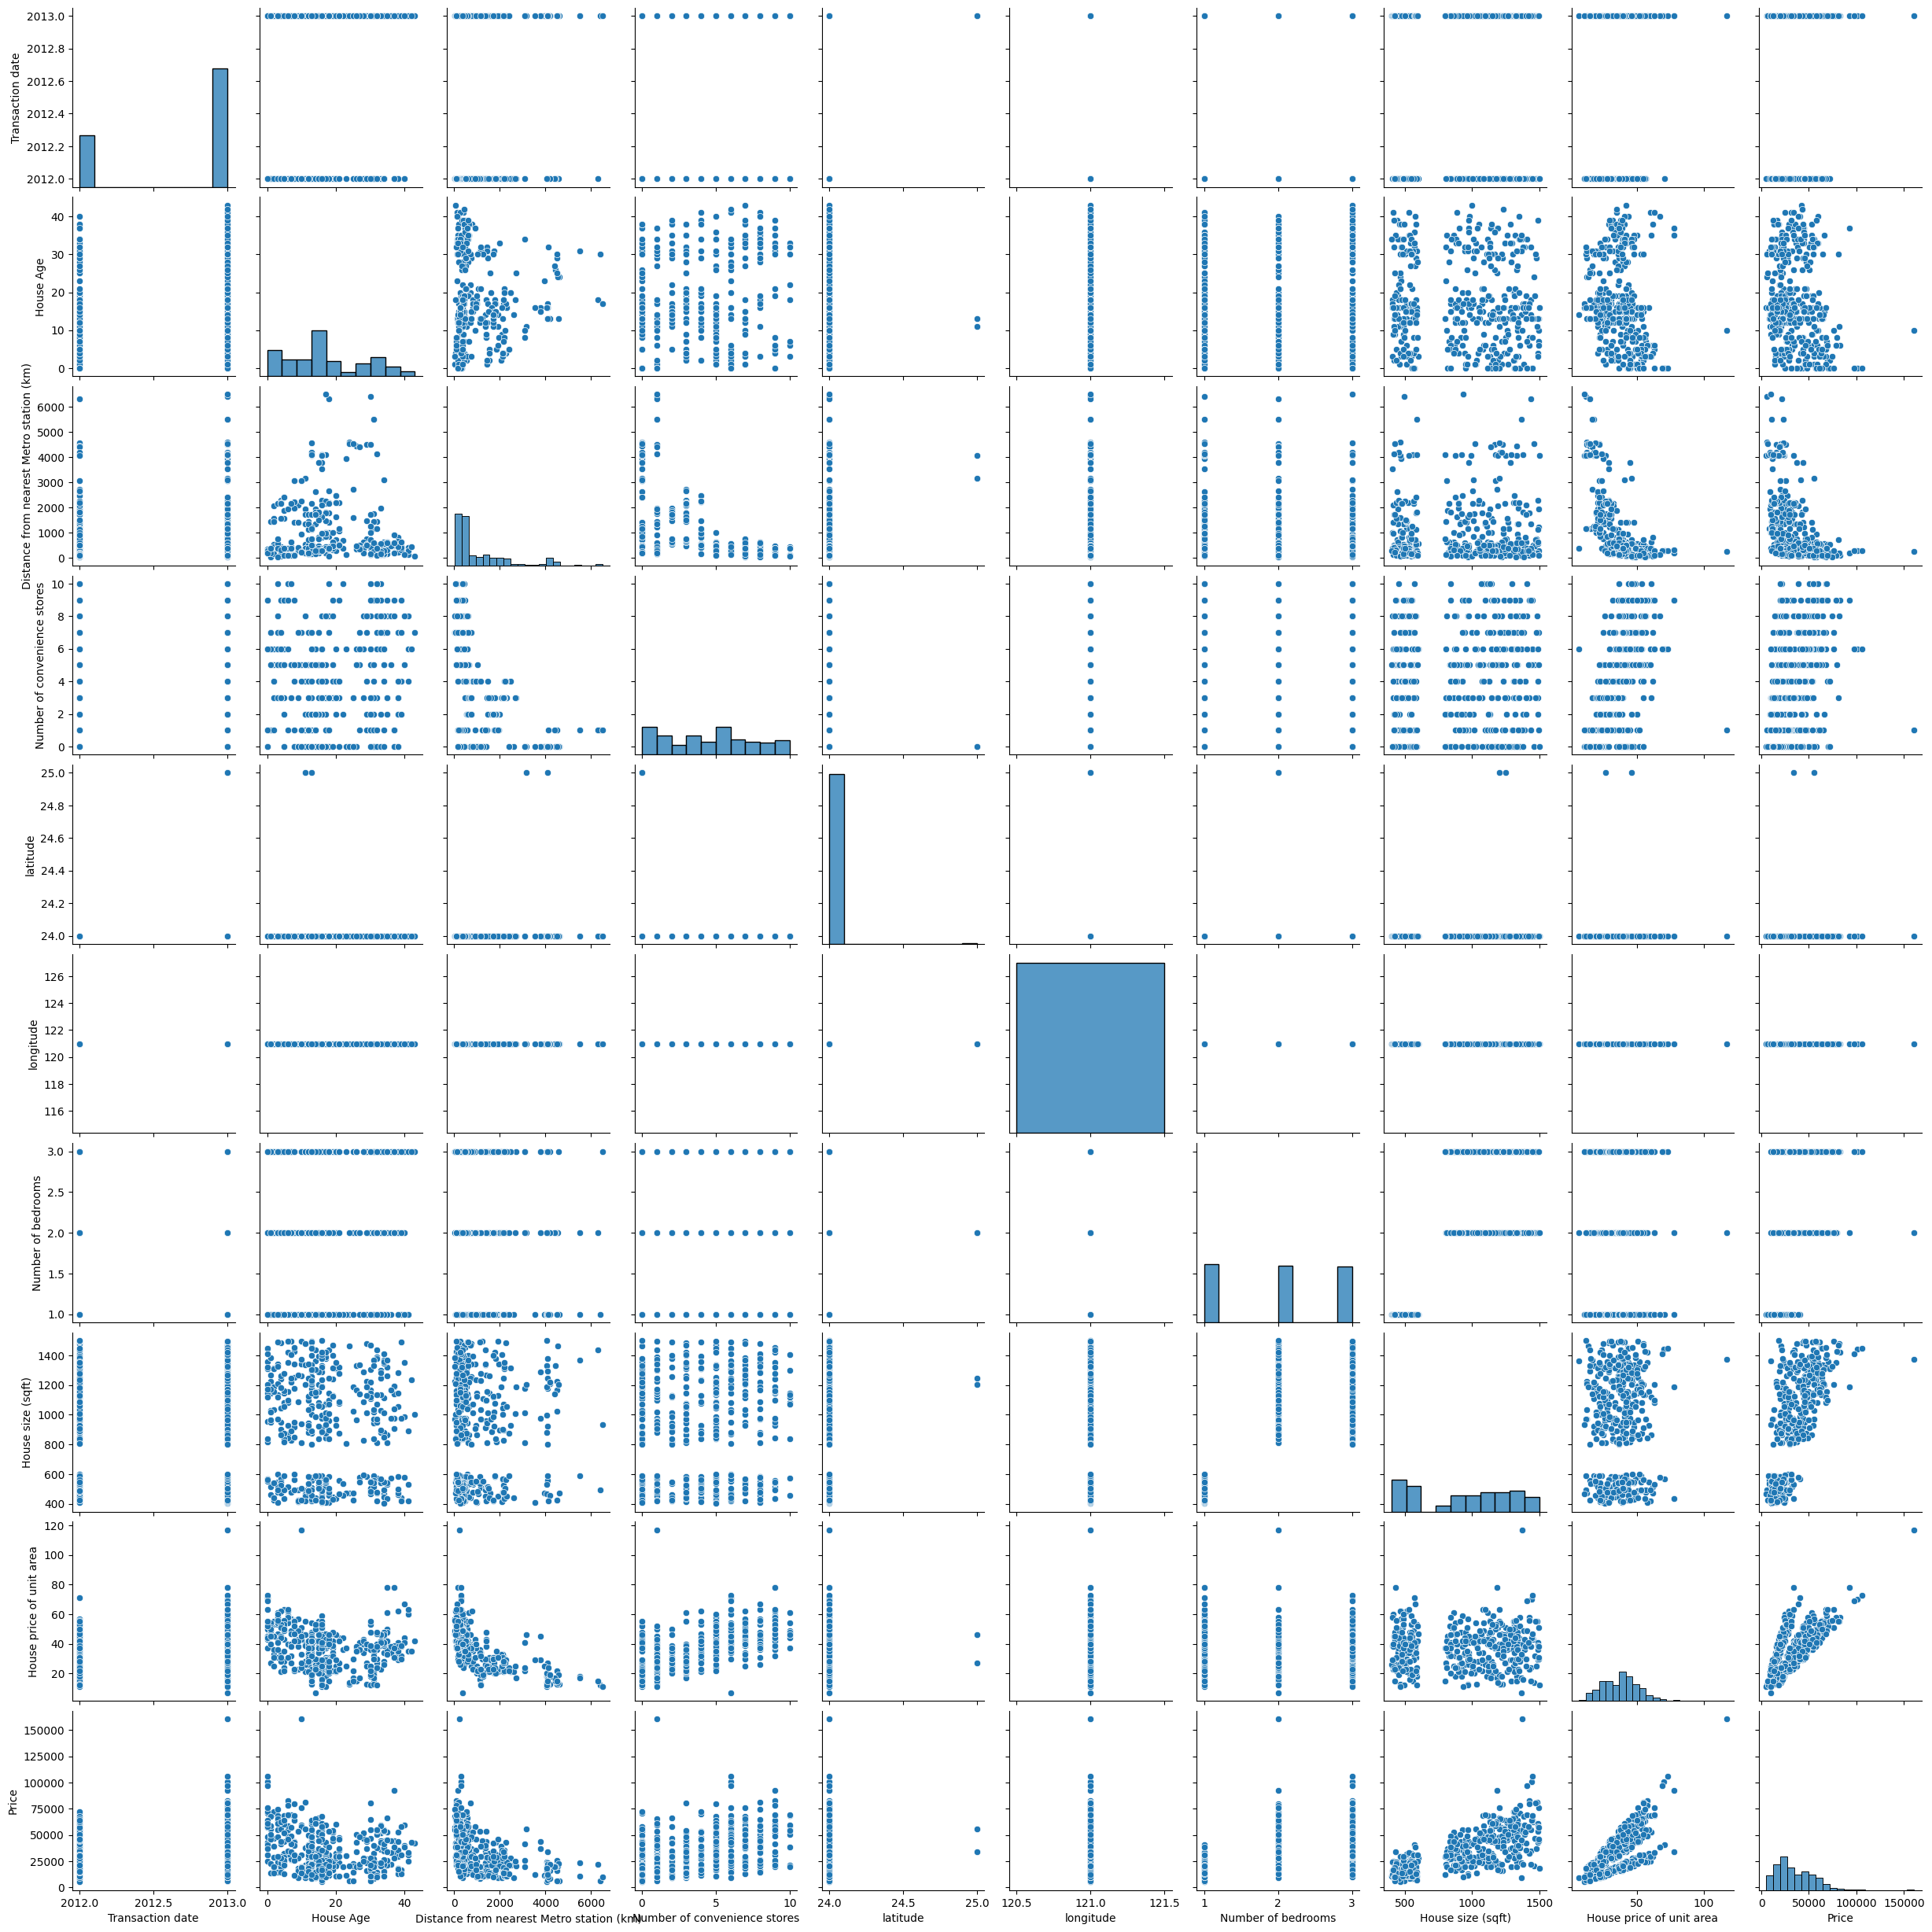

In [21]:
sns.pairplot(data)

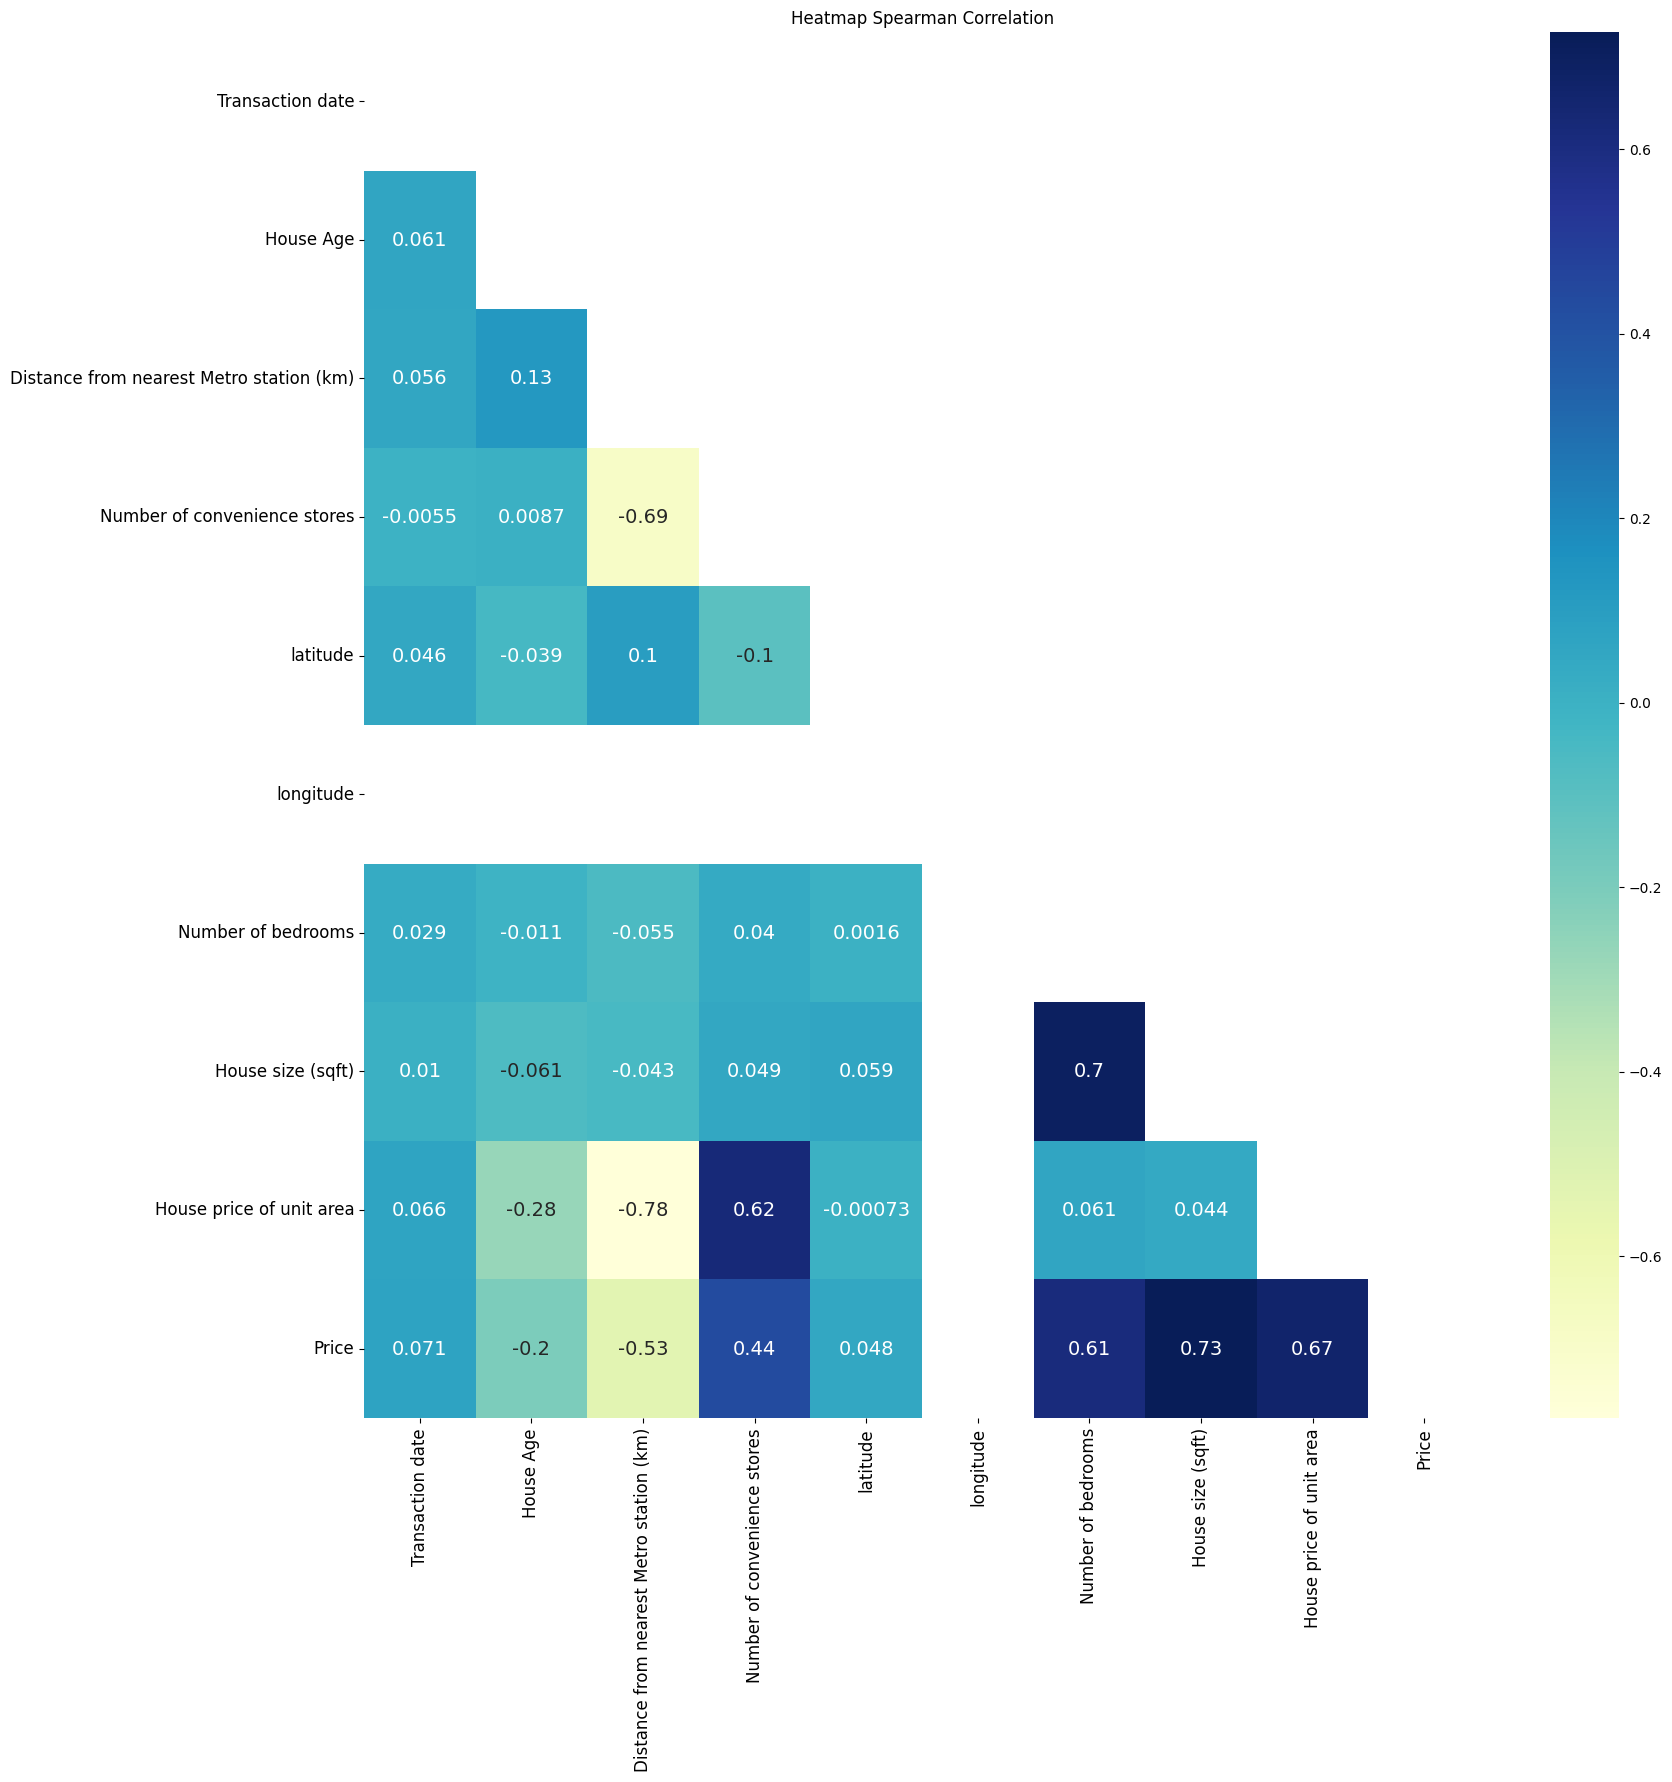

In [15]:
# HeatMap using Spearman Correlation
plt.figure(figsize=(18,18))
matrix = np.triu(data.corr(method='spearman'))
heat_map = sns.heatmap(data.corr(method='spearman'),annot=True,annot_kws={"size":14},cmap= 'YlGnBu',mask=matrix)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90)
plt.tick_params(labelsize=12)
plt.title('Heatmap Spearman Correlation')
plt.style.use('fivethirtyeight')

From heatmap we can see that:
1) Price and House size have highest positive correlation 0.73.
2) Correlation between House price of unit area	Number of convenience stores is negative which is -0.78.
3) Longitude and latitude has almost same values foor each data points they have zero variance. They will affect performance of a model. So we will remove them. 

In [16]:
X = data.drop(['Price','longitude', 'latitude'],axis=1)
Y = data['Price']

In [17]:
X.shape

(413, 7)

### **Data Processing:** ###

In [18]:
for column in X.columns:
    std = StandardScaler()
    X[column] = std.fit_transform(X[column].values.reshape((-1,1)))

In [19]:
# Function for computing metrics and showing results
def Computing_Metrics(y_true, y_pred):
    #1. MAE
    mae = mean_absolute_error(y_true, y_pred)
    #2. MSE
    mse = mean_squared_error(y_true, y_pred)
    #3. RMSE
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    #4. r2_score
    R2_score= r2_score(y_true,y_pred)
    
    dict_metrics = {'MAE' : [mae], 'MSE' : [mse], 'RMSE' : [rmse], 'R2_score' : [R2_score]}
    
    DF = pd.DataFrame(data=dict_metrics) 
    return  DF

In [21]:
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=0.25, random_state=25)

## **Machine Learning Model:** ##

### **1. Lasso Regression:** ###

In [22]:
#Parameters
parameters={'alpha':[1e-10,1e-6,1e-2,1,5,10,20,30,40]}
clf1=Lasso()
lasso=RandomizedSearchCV(clf1,parameters,scoring='neg_mean_squared_error',cv=5)
lasso.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=Lasso(),
                   param_distributions={'alpha': [1e-10, 1e-06, 0.01, 1, 5, 10,
                                                  20, 30, 40]},
                   scoring='neg_mean_squared_error')

In [23]:
print(lasso.best_params_)
print(lasso.best_score_)

{'alpha': 40}
-21738320.8916214


<AxesSubplot: xlabel='Price', ylabel='Density'>

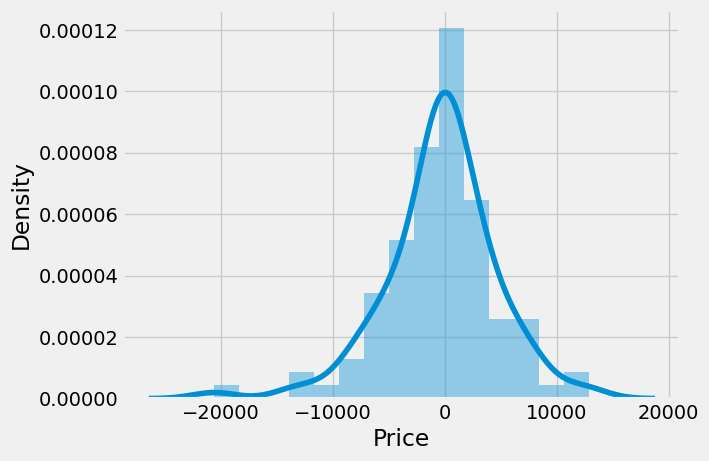

In [24]:
Y_lasso_pred=lasso.predict(X_test)
sns.distplot(Y_test-Y_lasso_pred)

Observations:

As we can see there is closely distributed gaussian distribution, so we can say that difference between predicted and real value is less.

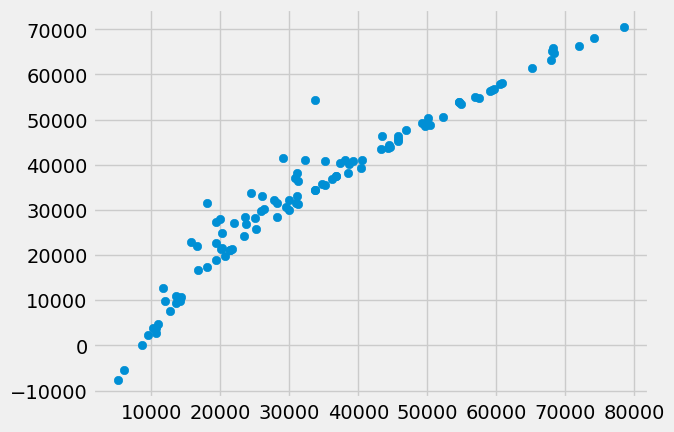

In [25]:
plt.scatter(Y_test,Y_lasso_pred)

In [26]:
#accuracy metrics
Lasso= Computing_Metrics(Y_test, Y_lasso_pred)
Lasso

,MAE,MSE,RMSE,R2_score
0,3433.221465,2.430498e+07,4930.007638,0.921342


### **2. KNeighborsRegressor:** ###

In [28]:
params={'leaf_size' : list(range(1,50)),
        'n_neighbors' : list(range(1,30)),
        'p': [1,2]}

clf_knn = KNeighborsRegressor()
Clf_knn = RandomizedSearchCV(clf_knn, params, n_iter=30, cv=5, verbose=10, random_state=42, n_jobs=-1)

In [29]:
Clf_knn.fit(X_train, Y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'p': [1, 2]},
                   random_state=42, verbose=10)

In [30]:
Y_knn_pred = Clf_knn.predict(X_test)
Clf_knn.best_estimator_

KNeighborsRegressor(leaf_size=37, n_neighbors=2)

In [31]:
KNN= Computing_Metrics(Y_test, Y_knn_pred)
KNN

,MAE,MSE,RMSE,R2_score
0,4083.514423,3.074756e+07,5545.048373,0.900492


<AxesSubplot: xlabel='Price', ylabel='Density'>

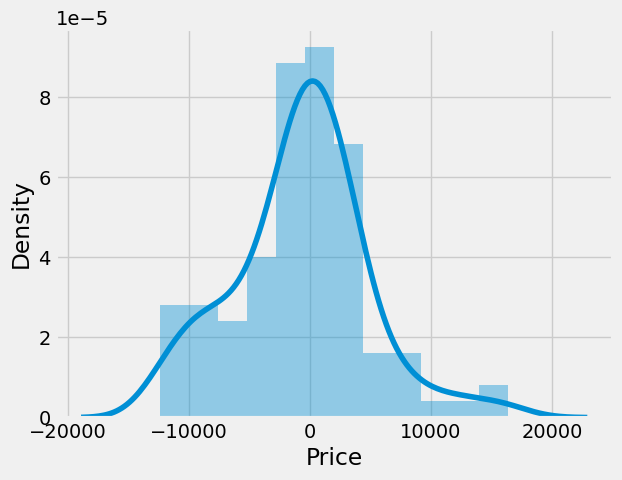

In [32]:
sns.distplot(Y_test-Y_knn_pred)

### **3. DecisionTreeRegressor:** ###

In [27]:
clf_dt = DecisionTreeRegressor()

criteria = ["mse", "friedman_mse", "mae", "poisson"]
splitter = ["best", "random"]
max_depth = list(np.arange(2,200,2))
min_samples_split = list(np.arange(1,100))
min_weight_fraction_leaf = list(np.linspace(0.0, 0.5))
max_features = ["auto", "sqrt", "log2"]
max_features.append(None)

params = {'criterion':criteria,
          'splitter':splitter,
          'max_depth':max_depth,
          'min_samples_split':min_samples_split,
          'min_weight_fraction_leaf':min_weight_fraction_leaf,
          'max_features':max_features
          }

Clf_dt = RandomizedSearchCV(clf_dt, params, n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

Clf_dt.fit(X_train, Y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'mae', 'poisson'],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24, 26,
                                                      28, 30, 32, 34, 36, 38,
                                                      40, 42, 44, 46, 48, 50,
                                                      52, 54, 56, 58, 60, ...],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14...
                                                                     0.1530612244897959,
                                                                     0.16326530612244897,
                                                                     0.17346938775510204,
                                                                     0.18367346938775508,
                                                                     0.19387755102040816,
                                                                     0.2040816326530612,
                                                                     0.21428571428571427,
                                                                     0.22448979591836732,
                                                                     0.2346938775510204,
                                                                     0.24489795918367346,
                                                                     0.25510204081632654,
                                                                     0.26530612244897955,
                                                                     0.2755102040816326,
                                                                     0.2857142857142857,
                                                                     0.29591836734693877, ...],
                                        'splitter': ['best', 'random']},
                   random_state=42, verbose=1)

In [33]:
Y_dt_pred = Clf_dt.predict(X_test)
Clf_dt.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=54,
                      min_samples_split=19,
                      min_weight_fraction_leaf=0.02040816326530612,
                      splitter='random')

In [34]:
DT= Computing_Metrics(Y_test, Y_dt_pred)
DT

,MAE,MSE,RMSE,R2_score
0,5628.830357,5.417874e+07,7360.620961,0.824662


### **4. RandomForestRegressor:** ###

In [35]:
clf_rf = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Clf_rf = RandomizedSearchCV(clf_rf, params, n_iter=5, cv=5, verbose=1, random_state=42)

Clf_rf.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=1)

In [36]:
Y_rf_pred = Clf_rf.predict(X_test)
Clf_rf.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=60, max_features='auto',
                      min_samples_leaf=2, n_estimators=600)

In [37]:
RF= Computing_Metrics(Y_test, Y_rf_pred)
RF

,MAE,MSE,RMSE,R2_score
0,2172.855996,9.107163e+06,3017.807672,0.970527


### **5. XGBRegressor:** ###

In [38]:
clf_xgb = XGBRegressor(objective='reg:squarederror', tree_method='exact')

params = {'max_depth': [2, 4, 6],
              'gamma': [0, 0.2],
              'learning_rate': [0.01, 0.02, 0.3, 0.4], 
              'n_estimators': [100, 500], 
              'min_child_weight': [1, 4, 6],
              'subsample': [0.8], 
              'colsample_bytree': [0.8]
          }

Clf_xgb = RandomizedSearchCV(clf_xgb, params, n_iter=5, cv=5, verbose=10, random_state=42)

Clf_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.8
[CV 1/5; 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.8;, score=0.968 total time=   1.2s
[CV 2/5; 1/5] START colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.8
[CV 2/5; 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.8;, score=0.979 total time=   0.1s
[CV 3/5; 1/5] START colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.8
[CV 3/5; 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.8;, score=0.979 total time=   0.1s
[CV 4/5; 1/5] START colsa

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.8],
                                        'gamma': [0, 0.2],
                                        'learning_rate': [0.01, 0.02, 0.3, 0.4],
                                        'max_depth': [2, 4, 6],
                                        'min_child_weight': [1, 4, 6],
                                        'n_estimators': [100, 500],
                                        'subsample': [0.8]},
                   random_state=42, verbose=10)

In [39]:
Y_xgb_pred = Clf_xgb.predict(X_test)
Clf_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.2, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [40]:
XGB= Computing_Metrics(Y_test, Y_xgb_pred)
XGB

,MAE,MSE,RMSE,R2_score
0,932.526855,1.772717e+06,1331.434365,0.994263


### **6. GradientBoostingRegressor** ###

In [41]:
clf_gbr = GradientBoostingRegressor()
params = {
    "alpha":[0.01, 0.3, 0.5, 0.8, 1, 1.5],
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

Clf_gbr = RandomizedSearchCV(clf_gbr, params, n_iter=5, cv=5, verbose=1, random_state=42)

Clf_gbr.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=5,
                   param_distributions={'alpha': [0.01, 0.3, 0.5, 0.8, 1, 1.5],
                                        'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [5, 50, 250, 500]},
                   random_state=42, verbose=1)

In [42]:
Y_gbr_pred = Clf_gbr.predict(X_test)
Clf_gbr.best_estimator_

GradientBoostingRegressor(alpha=0.3, learning_rate=0.01, n_estimators=250)

In [43]:
GBR= Computing_Metrics(Y_test, Y_gbr_pred)
GBR

,MAE,MSE,RMSE,R2_score
0,2460.081458,9.202085e+06,3033.493838,0.970219


### **Observations:** ###

In [44]:
# Creating a list of all the model metric dfs
metric_df = pd.concat([Lasso, KNN, DT, RF, XGB, GBR])
metric_df['Model'] = ['Lasso','KNN', 'DT', 'RF', 'XGB', 'GBR']
metric_df.set_index('Model', inplace=True)

In [45]:
Metric_df = metric_df.transpose() 
Metric_df

Model,Lasso,KNN,DT,RF,XGB,GBR
MAE,3.433221e+03,4.083514e+03,5.628830e+03,2.172856e+03,9.325269e+02,2.460081e+03
MSE,2.430498e+07,3.074756e+07,5.417874e+07,9.107163e+06,1.772717e+06,9.202085e+06
RMSE,4.930008e+03,5.545048e+03,7.360621e+03,3.017808e+03,1.331434e+03,3.033494e+03
R2_score,9.213423e-01,9.004922e-01,8.246623e-01,9.705267e-01,9.942630e-01,9.702195e-01


**Conclusion:**

From table we can see that XGB has less MAE, MSE, RMSE AND high r2_score compared to others. Also xgboost can handle outliers and missing values by its own. so we will choose it as final model